# Recommender System - Model Development
This notebook demonstrates building a recommendation system on the Amazon Reviews 2023 dataset. It includes data loading, preprocessing, model training, evaluation, and generating sample recommendations. The dataset is sourced from the Hugging Face datasets library [Amazon Reviews 2023](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023) based on paper [Bridging Language and Items for Retrieval and Recommendation (2024)](
https://doi.org/10.48550/arXiv.2403.03952
).

In [1]:
import os
import random
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from collections import defaultdict

# os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
# os.environ["HF_DATASETS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"
# os.environ["TRANSFORMERS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/models"

os.environ["HF_HOME"] = "E:/Python Scripts/recsys"
os.environ['HF_DATASETS_CACHE'] = "E:/Python Scripts/recsys/data"
os.environ['TRANSFORMERS_CACHE'] = "E:/Python Scripts/recsys/models"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Features, Value
from tqdm import tqdm
from tensorboardX import SummaryWriter

In [2]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Loading the dataset
The dataset is loaded from the Hugging Face datasets library, Amazon Reviews 2023.

In [3]:
USE_HF = True
HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"
HF_DOMAIN = "Books"

def load_amazon_reviews(domain, save_dir="data", max_items=None, seed=SEED):
    os.makedirs(save_dir, exist_ok=True)
    filepath = f"{save_dir}/amazon_reviews_{domain}.csv"

    if not os.path.exists(filepath):
        print(f"File {filepath} not found. Downloading dataset for domain '{domain}'...")
        ds = load_dataset(
            "McAuley-Lab/Amazon-Reviews-2023",
            f"raw_review_{domain}",
            split="full",
            trust_remote_code=True,
        )

        ds = ds.select_columns(["user_id", "parent_asin", "rating", "timestamp"])
        ds = ds.rename_columns({"user_id": "user", "parent_asin": "item"})
        ds = ds.cast(Features({
            "user": Value("string"),
            "item": Value("string"),
            "rating": Value("float32"),
            "timestamp": Value("int64"),
        }))

        df = ds.to_pandas()
        df.insert(3, "domain", domain)
        df.to_csv(f"{save_dir}/amazon_reviews_{domain}.csv", index=False)
        print(f"Saved amazon_reviews_{domain}.csv to {save_dir}/")

    final_df = pd.read_csv(filepath)
    if max_items is not None:
        k = min(max_items, len(final_df))
        final_df = final_df.sample(n=k, random_state=seed).reset_index(drop=True)
    print(f"Loaded {filepath} with {len(final_df)} rows.")
    return final_df

df = load_amazon_reviews(HF_DOMAIN, save_dir="data", max_items=5_000_000, seed=SEED)
print(f"Loaded {len(df)} rows from {HF_DOMAIN} domain.")

Loaded data/amazon_reviews_Books.csv with 5000000 rows.
Loaded 5000000 rows from Books domain.


In [4]:
df.head()

,user,item,rating,domain,timestamp
0,AEADNN27WH7SOS6QFJYFJSITC7FQ,1847252370,5.0,Books,1358572717000
1,AETNE77ZXSJST5PWIXABKOXPLNNA,1904563643,5.0,Books,1571550861633
2,AF6Q3Y4FWKXXMROUWKMHGHD35Z6Q,B09L91L8WJ,5.0,Books,1636685186681
3,AH7JAKZVXUS6YK3EUDVBPZ5QQO4A,0999877003,5.0,Books,1674101452159
4,AFAA3ZUA3ERM2MGCR3WP3VADLXYA,0393624587,5.0,Books,1563584263663


## Preprocessing the dataset
- Make it implicit by considering all ratings as positive interactions.
- Filter out users and items with less than 5 interactions.
- Create a mapping of user and item IDs to indices.

In [5]:
# Make implicit dataset, filter users/items with less than k interactions
def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    df["label"] = 1.0 # Make it implicit
    user_counts = df["user"].value_counts()
    item_counts = df["item"].value_counts()
    valid_users = user_counts[user_counts >= min_user_interactions].index
    valid_items = item_counts[item_counts >= min_item_interactions].index
    df = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)].copy()
    print("After interactions filtering:", len(df), "rows,", df["user"].nunique(), "users,", df["item"].nunique(), "items")
    return df

def label_encoder(df):
    df_enc = df.copy()
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    df_enc["user_id"] = user_enc.fit_transform(df_enc["user"])
    df_enc["item_id"] = item_enc.fit_transform(df_enc["item"])
    return df_enc, user_enc, item_enc

filtered_df = preprocess_dataset(df, min_user_interactions=10, min_item_interactions=10)
df_encoded, user_enc, item_enc = label_encoder(filtered_df)

After interactions filtering: 183771 rows, 26817 users, 49641 items


In [6]:
def calculate_data_sparsity(df):
    num_users = df["user"].nunique()
    num_items = df["item"].nunique()
    num_interactions = len(df)
    density = num_interactions / (num_users * num_items)
    sparsity = 1 - density

    print(f"Number of users: {num_users}")
    print(f"Number of items: {num_items}")
    print(f"Number of interactions: {num_interactions}")
    print(f"-" * 30)
    print(f"Interaction Matrix Density: {density:.6f}")
    print(f"Interaction Matrix Sparsity: {sparsity:.6f}")

calculate_data_sparsity(df_encoded)

Number of users: 26817
Number of items: 49641
Number of interactions: 183771
------------------------------
Interaction Matrix Density: 0.000138
Interaction Matrix Sparsity: 0.999862


In [7]:
def loo_split(df):
    df = df.sort_values(["user_id", "timestamp"])
    train_rows, val_rows, test_rows = [], [], []

    for uid, group in df.groupby("user_id", sort=False):
        g = group.sort_values("timestamp")
        if len(g) < 3:
            train_rows.append(g)
            continue
        test_rows.append(g.iloc[[-1]]) # Last interaction as test
        val_rows.append(g.iloc[[-2]]) # Second last interaction as validation
        train_rows.append(g.iloc[:-2]) # All but last two as training

    train_df = pd.concat(train_rows, ignore_index=True)
    val_df = pd.concat(val_rows, ignore_index=True)
    test_df = pd.concat(test_rows, ignore_index=True)

    return train_df, val_df, test_df

train_df, val_df, test_df = loo_split(df_encoded)
print(f"Train/Validation/Test split: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Validation/Test split: 142045, 20863, 20863


## Building the dataset with negative sampling

In [8]:
NUM_USERS = df_encoded["user_id"].max() + 1
NUM_ITEMS = df_encoded["item_id"].max() + 1

In [9]:
# Rank the single positive against k negative samples for train and evaluation
def build_pos_items_by_user(train_df):
    pos_items_by_user = defaultdict(set)
    for u, i in zip(train_df["user_id"].values, train_df["item_id"].values):
        pos_items_by_user[u].add(int(i))
    return pos_items_by_user

In [10]:
# Training dataset with k negatives per positive
class CustomDataset(Dataset):
    def __init__(self, df, num_items, pos_by_user, n_neg=4, mode="train", seed=SEED):
        self.pos_pairs = df[["user_id", "item_id"]].values.astype(np.int64)
        self.users = self.pos_pairs[:, 0]
        self.pos_items = self.pos_pairs[:, 1]
        self.num_items = num_items
        self.n_neg = n_neg
        self.mode = mode
        self.pos_by_user = pos_by_user
        self.rng = np.random.default_rng(seed)

        if mode == "val" or mode == "test":
            self.eval_candidates = np.empty((len(self.users), 1 + self.n_neg), dtype=np.int64)
            for idx, (u, pos_i) in enumerate(zip(self.users, self.pos_items)):
                user_pos = self.pos_by_user[u].copy()
                user_pos.add(pos_i)
                negs = []
                while len(negs) < self.n_neg:
                    neg = self.rng.integers(0, self.num_items)
                    if neg not in user_pos:
                        negs.append(int(neg))
                        user_pos.add(neg)
                self.eval_candidates[idx, 0] = pos_i
                self.eval_candidates[idx, 1:] = np.asarray(negs, dtype=np.int64)

    def __len__(self):
        return len(self.pos_pairs) * (1 + self.n_neg) if self.mode == "train" else len(self.users)

    def __getitem__(self, idx):
        if self.mode == "train":
            return self._get_train_item(idx)
        else:
            return self._get_eval_item(idx)

    def _get_train_item(self, idx):
        pos_idx = idx // (self.n_neg + 1)
        is_pos = (idx % (self.n_neg + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), np.float32(1.0)

        while True:
            j = self.rng.integers(0, self.num_items)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), np.float32(0.0)

    def _get_eval_item(self, idx):
        return int(self.users[idx]), self.eval_candidates[idx]


pos_items_by_user = build_pos_items_by_user(train_df)

train_dataset = CustomDataset(train_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=4, mode="train", seed=SEED)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

val_dataset = CustomDataset(val_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="val", seed=SEED)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

test_dataset = CustomDataset(test_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="test", seed=SEED)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"Training dataset created with {len(train_dataset)} samples.")
print(f"Validation dataset created with {len(val_dataset)} samples.")
print(f"Test dataset created with {len(test_dataset)} samples.")

Training dataset created with 710225 samples.
Validation dataset created with 20863 samples.
Test dataset created with 20863 samples.


## Utility functions for training and evaluation
- Train one epoch
- For each val user, build candidate set = `{positive} U {k negatives}`
- Score, sort, compute HR@K, NDCG@K, Precision@K, MAP@K

In [11]:
def train_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc="Training"):
        users, items, labels = batch
        users = users.to(device)
        items = items.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(users, items)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    epoch_loss = running_loss / max(n_batches, 1)
    return epoch_loss

In [12]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_ap = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for users, cand in tqdm(eval_loader, desc="Evaluating"):
        users = users.to(device, non_blocking=True)
        cand = torch.as_tensor(cand, dtype=torch.long, device=device)
        B, C = cand.shape

        # Repeat users per candidate, score in one forward
        users_rep = users.view(-1, 1).expand(-1, C).reshape(-1)
        items_flat = cand.reshape(-1)
        scores_flat = model(users_rep, items_flat)
        scores = scores_flat.view(B, C)

        # Rank of the positive (column 0)
        pos = scores[:, 0].unsqueeze(1)  # [B,1]
        rank = (scores[:, 1:] > pos).sum(dim=1).add_(1).to(torch.long)

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        ap = hit / rank

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_ap += ap.sum().item()
        total += B

        # Validation loss: labels = [1, 0, 0, ...]
        labels = torch.zeros_like(scores)
        labels[:, 0] = 1.0
        batch_loss = loss_fn(scores, labels)
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MAP@K": sum_ap / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }
    return metrics

## Train loop

In [13]:
def model_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        t0 = time.time()

        # Train
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device=device)
        train_losses.append(train_loss)

        # Eval
        m = evaluate(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MAP@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MAP@{k} {m['MAP@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch == epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    print("\nTraining Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return train_losses, val_losses, val_metrics_log, best_ndcg

## Baseline model: Matrix factorization

A simple Matrix Factorization model with user and item embeddings with dot product scoring.

In [14]:
# Simple Matrix Factorization model (dot product)
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim):
        super().__init__()
        self.user_embed = nn.Embedding(n_users, embedding_dim)
        self.item_embed = nn.Embedding(n_items, embedding_dim)
        nn.init.uniform_(self.user_embed.weight, 0., 0.05)
        nn.init.uniform_(self.user_embed.weight, 0., 0.05)

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        dot_product = (user_embeds * item_embeds).sum(dim=1)
        return dot_product

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user"""
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(next(self.parameters()).device)
        all_items = torch.arange(self.item_embed.num_embeddings).to(next(self.parameters()).device)
        user_embeds = self.user_embed(user_tensor)
        item_embeds = self.item_embed(all_items)
        scores = torch.matmul(user_embeds, item_embeds.T).squeeze()
        return torch.sigmoid(scores)

In [15]:
# Run the training
model = MatrixFactorization(n_users=NUM_USERS, n_items=NUM_ITEMS, embedding_dim=64).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses, val_losses, val_metrics, best_ndcg = model_trainer(
    model=model,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    k=10,
    device=DEVICE
)

Evaluating: 100%|██████████| 41/41 [00:00<00:00, 133.26it/s]


Epoch 1/20  Train loss 0.6928  Val loss 0.6884  HR@10 0.1131  NDCG@10 0.0535  Precision@10 0.0113  MAP@10 0.0358  (new best)  Time 12.82s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 171.96it/s]


Epoch 2/20  Train loss 0.6662  Val loss 0.6712  HR@10 0.1332  NDCG@10 0.0661  Precision@10 0.0133  MAP@10 0.0461  (new best)  Time 12.33s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 189.75it/s]


Epoch 3/20  Train loss 0.6300  Val loss 0.6215  HR@10 0.1740  NDCG@10 0.0924  Precision@10 0.0174  MAP@10 0.0678  (new best)  Time 12.43s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 175.77it/s]


Epoch 4/20  Train loss 0.5602  Val loss 0.5216  HR@10 0.2178  NDCG@10 0.1164  Precision@10 0.0218  MAP@10 0.0858  (new best)  Time 12.43s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 187.64it/s]


Epoch 5/20  Train loss 0.4780  Val loss 0.4151  HR@10 0.2330  NDCG@10 0.1247  Precision@10 0.0233  MAP@10 0.0920  (new best)  Time 12.39s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 185.19it/s]


Epoch 6/20  Train loss 0.4220  Val loss 0.3451  HR@10 0.2357  NDCG@10 0.1265  Precision@10 0.0236  MAP@10 0.0935  (new best)  Time 12.36s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 180.19it/s]


Epoch 7/20  Train loss 0.3893  Val loss 0.3068  HR@10 0.2362  NDCG@10 0.1253  Precision@10 0.0236  MAP@10 0.0918    Time 12.30s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 180.89it/s]


Epoch 8/20  Train loss 0.3668  Val loss 0.2846  HR@10 0.2381  NDCG@10 0.1263  Precision@10 0.0238  MAP@10 0.0926    Time 12.46s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 178.21it/s]


Epoch 9/20  Train loss 0.3469  Val loss 0.2701  HR@10 0.2383  NDCG@10 0.1260  Precision@10 0.0238  MAP@10 0.0922    Time 12.25s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 167.98it/s]


Epoch 10/20  Train loss 0.3279  Val loss 0.2593  HR@10 0.2379  NDCG@10 0.1255  Precision@10 0.0238  MAP@10 0.0916    Time 12.37s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 186.27it/s]


Epoch 11/20  Train loss 0.3093  Val loss 0.2503  HR@10 0.2381  NDCG@10 0.1253  Precision@10 0.0238  MAP@10 0.0912    Time 12.09s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 165.29it/s]


Epoch 12/20  Train loss 0.2913  Val loss 0.2423  HR@10 0.2364  NDCG@10 0.1254  Precision@10 0.0236  MAP@10 0.0918    Time 12.62s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 158.34it/s]


Epoch 13/20  Train loss 0.2734  Val loss 0.2353  HR@10 0.2380  NDCG@10 0.1264  Precision@10 0.0238  MAP@10 0.0927    Time 12.99s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 173.45it/s]


Epoch 14/20  Train loss 0.2575  Val loss 0.2290  HR@10 0.2411  NDCG@10 0.1273  Precision@10 0.0241  MAP@10 0.0929  (new best)  Time 12.79s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 158.12it/s]


Epoch 15/20  Train loss 0.2432  Val loss 0.2232  HR@10 0.2396  NDCG@10 0.1271  Precision@10 0.0240  MAP@10 0.0931    Time 12.55s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 177.97it/s]


Epoch 16/20  Train loss 0.2303  Val loss 0.2183  HR@10 0.2410  NDCG@10 0.1288  Precision@10 0.0241  MAP@10 0.0949  (new best)  Time 12.45s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 174.30it/s]


Epoch 17/20  Train loss 0.2194  Val loss 0.2139  HR@10 0.2391  NDCG@10 0.1287  Precision@10 0.0239  MAP@10 0.0953    Time 12.47s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 193.10it/s]


Epoch 18/20  Train loss 0.2101  Val loss 0.2100  HR@10 0.2401  NDCG@10 0.1294  Precision@10 0.0240  MAP@10 0.0960  (new best)  Time 12.41s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 171.14it/s]


Epoch 19/20  Train loss 0.2019  Val loss 0.2067  HR@10 0.2422  NDCG@10 0.1308  Precision@10 0.0242  MAP@10 0.0971  (new best)  Time 12.29s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 175.68it/s]


Epoch 20/20  Train loss 0.1953  Val loss 0.2038  HR@10 0.2442  NDCG@10 0.1323  Precision@10 0.0244  MAP@10 0.0985  (new best)  Time 12.23s

Training Complete.
Best epoch: 20 with NDCG@10: 0.1323



## Final evaluation on test set and sample recommendations

In [16]:
def load_best_weights(model, ckpt_path="model/best_model.pth", device="cpu"):
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location="cpu")
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

best_model = load_best_weights(model, ckpt_path="model/best_model.pth", device=DEVICE)

In [17]:
# Final evaluation on test set
@torch.no_grad()
def final_evaluation_loader(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
            "MAP@K": metrics["MAP@K"],
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

results_df_mf = final_evaluation_loader(best_model, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 41/41 [00:00<00:00, 184.68it/s]

     HR@K  NDCG@K  Precision@K  MAP@K
K                                    
5  0.1296  0.0843       0.0259 0.0694
10 0.2046  0.1084       0.0205 0.0793
20 0.3200  0.1373       0.0160 0.0871
50 0.5662  0.1858       0.0113 0.0947


In [18]:
@torch.no_grad()
def get_recommendations(
    model, user_id, pos_items_by_user, item_encoder, top_k=10, exclude_interacted=True, as_prob=False
):
    model.eval()
    scores = model.predict_all_items(user_id)  # logits
    if exclude_interacted and user_id in pos_items_by_user:
        idx = torch.as_tensor(list(pos_items_by_user[user_id]), dtype=torch.long, device=scores.device)
        if idx.numel() > 0:
            scores.index_fill_(0, idx, float('-inf'))

    top_scores, top_indices = torch.topk(scores, k=top_k)
    shown = torch.sigmoid(top_scores) if as_prob else top_scores

    item_ids_np = top_indices.detach().cpu().numpy()
    items_np = item_encoder.inverse_transform(item_ids_np)
    return [{"item_id": int(i), "item": it, "score": float(s)} for i, it, s in zip(item_ids_np, items_np, shown.detach().cpu().numpy())]

In [19]:
def build_history_by_user(df):
    # df must contain user_id, item_id, timestamp (ints)
    df_sorted = df.sort_values(["user_id", "timestamp"])
    hist = defaultdict(list)
    for u, i in zip(df_sorted["user_id"].values, df_sorted["item_id"].values):
        hist[u].append(int(i))
    return hist

# Use training history for "no future knowledge"
history_by_user_train = build_history_by_user(train_df)

In [20]:
def show_sample_recommendations(
    model,
    df,
    user_encoder,
    item_encoder,
    pos_items_by_user,
    history_by_user,
    num_users=5,
    top_k=10
):
    print("\n" + "="*50)
    print("User Sample Recommendations")
    print("="*50)

    user_candidates = df["user_id"].unique().tolist()
    for user_id in random.sample(user_candidates, k=min(num_users, len(user_candidates))):
        original_user = user_encoder.inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        recent = history_by_user.get(user_id, [])[-5:]  # last 5 chronologically
        print("Recent interactions:")
        for item_id in reversed(recent):  # most recent first
            print("  -", item_encoder.inverse_transform([item_id])[0])

        recs = get_recommendations(
            model,
            user_id=user_id,
            pos_items_by_user=pos_items_by_user,
            item_encoder=item_encoder,
            top_k=top_k,
            exclude_interacted=True
        )
        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec['item']} (Score: {rec['score']:.4f})")

In [21]:
# “Online-style”
show_sample_recommendations(
    best_model,
    df_encoded,
    user_enc,
    item_enc,
    pos_items_by_user=pos_items_by_user,
    history_by_user=history_by_user_train,
    num_users=5, top_k=10
)


User Sample Recommendations

User: AH4537YJEUOLTO6XFIPH5B3WYCJQ (ID: 20492)
----------------------------------------
Recent interactions:
  - B004QZ9PJ2

Top 10 Recommendations:
  1. B00L9B7IKE (Score: 0.6299)
  2. B07JW53H22 (Score: 0.5933)
  3. B006LSZECO (Score: 0.5812)
  4. 0439023491 (Score: 0.5778)
  5. 030758836X (Score: 0.5763)
  6. B01M7XPGYE (Score: 0.5749)
  7. B016ZNRC0Q (Score: 0.5748)
  8. 0375842209 (Score: 0.5744)
  9. 0307588378 (Score: 0.5682)
  10. B07D6PZ6P1 (Score: 0.5643)

User: AF5NVM6IJCCOOVETAN37BEJ2A5MA (ID: 7511)
----------------------------------------
Recent interactions:
  - B074ZKDWT2
  - B01MDQ6HFA
  - 1492626015
  - 1401307469
  - 1501132938

Top 10 Recommendations:
  1. 0439023513 (Score: 0.9838)
  2. B00L9B7IKE (Score: 0.9828)
  3. B016ZNRC0Q (Score: 0.9756)
  4. 0316134023 (Score: 0.9592)
  5. B00SLWQGUM (Score: 0.9464)
  6. B006LSZECO (Score: 0.9412)
  7. B01MQ2HAAJ (Score: 0.9393)
  8. B019DKO5BM (Score: 0.9390)
  9. 038549081X (Score: 0.9369)
  1

## Plotting training history

In [24]:
def plot_training_history(train_losses, val_losses, val_metrics, k, model_name, save_path="training_history.png"):
    """Plot training history and validation metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"{model_name}", fontsize=16)

    # Plot training and validation loss
    axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    axes[0, 0].plot(val_losses, label="Validation Loss", color="red")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training vs Validation Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot training loss
    #axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    #axes[0, 0].set_xlabel("Epoch")
    #axes[0, 0].set_ylabel("Loss")
    #axes[0, 0].set_title("Training Loss")
    #axes[0, 0].legend()
    #axes[0, 0].grid(True, alpha=0.3)

    # Plot HR@k
    hr_values = [m["HR@K"] for m in val_metrics]
    axes[0, 1].plot(hr_values, label=f"Val HR@{k}", color="green", marker="o")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel(f"HR@{k}")
    axes[0, 1].set_title(f"Validation Hit Rate@{k}")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot NDCG@k
    ndcg_values = [m["NDCG@K"] for m in val_metrics]
    axes[0, 2].plot(ndcg_values, label=f"Val NDCG@{k}", color="orange", marker="s")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylabel(f"NDCG@{k}")
    axes[0, 2].set_title(f"Validation NDCG@{k}")
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot Precision@k
    precision_values = [m["Precision@K"] for m in val_metrics]
    axes[1, 0].plot(precision_values, label=f"Val Precision@{k}", color="purple", marker="^")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel(f"Precision@{k}")
    axes[1, 0].set_title(f"Validation Precision@{k}")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot MAP@k for MF model and Neumf, MRR@K for SASRec
    first_metrics = val_metrics[0] if len(val_metrics) > 0 else {}
    metric_key = "MAP@K" if "MAP@K" in first_metrics else ("MRR@K" if "MRR@K" in first_metrics else None)
    metric_label = "MAP@" if metric_key == "MAP@K" else ("MRR@" if metric_key == "MRR@K" else "Metric@")

    recall_values = [m[metric_key] for m in val_metrics]
    axes[1, 1].plot(recall_values, label=f"Val {metric_label}{k}", color="brown", marker="v")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel(f"{metric_label}{k}")
    axes[1, 1].set_title(f"Validation {metric_label}{k}")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot all metrics together for comparison
    axes[1, 2].plot(hr_values, label=f"HR@{k}", marker="o")
    axes[1, 2].plot(ndcg_values, label=f"NDCG@{k}", marker="s")
    axes[1, 2].plot(precision_values, label=f"Precision@{k}", marker="^")
    axes[1, 2].plot(recall_values, label=f"{metric_label}{k}", marker="v")
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Score")
    axes[1, 2].set_title("All Validation Metrics Comparison")
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches="tight")
    plt.show()

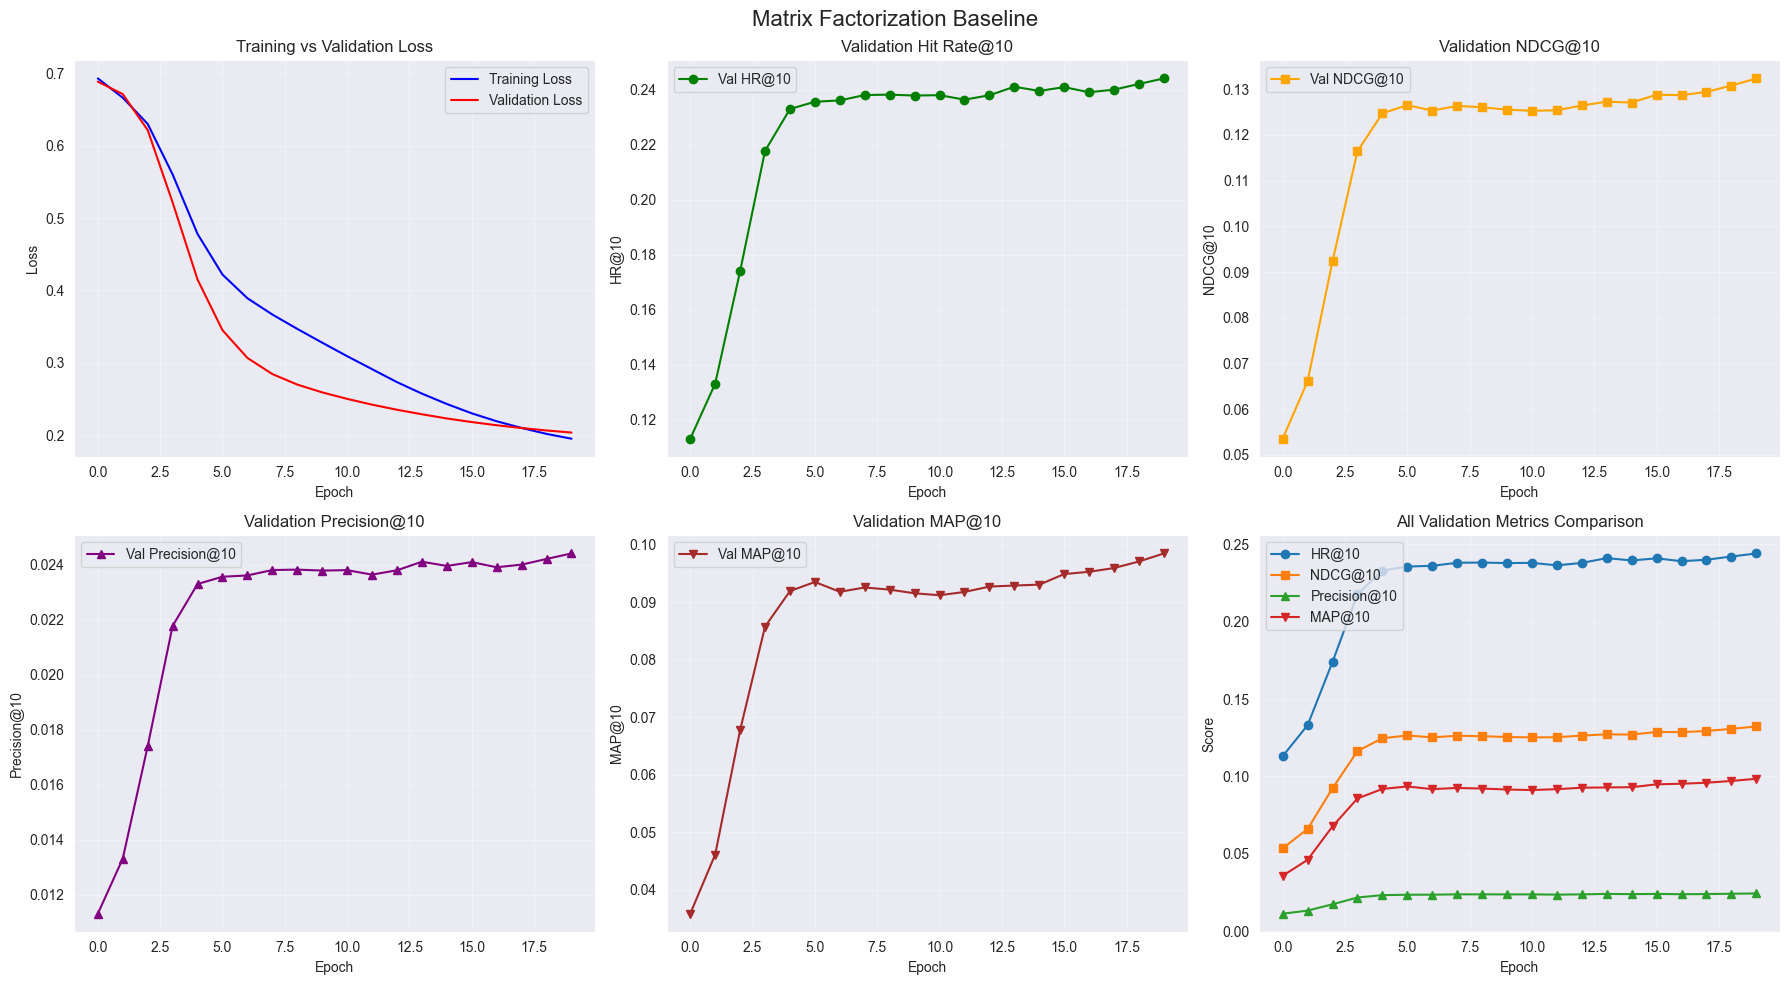

In [25]:
plot_training_history(
    train_losses,
    val_losses,
    val_metrics,
    k=10,
    model_name="Matrix Factorization Baseline",
    save_path="training_history.png"
)

## Model 1: Neural matrix factorization model

In [26]:
class NeuralMF(nn.Module):
    def __init__(
        self,
        n_users: int,
        n_items: int,
        gmf_dim: int = 32,
        mlp_dim: int = 32,
        mlp_layers=(64, 32, 16),
        dropout: float = 0.1,
        use_bias: bool = True,
    ):
        super().__init__()
        # GMF
        self.user_emb_gmf = nn.Embedding(n_users, gmf_dim)
        self.item_emb_gmf = nn.Embedding(n_items, gmf_dim)

        # MLP
        self.user_emb_mlp = nn.Embedding(n_users, mlp_dim)
        self.item_emb_mlp = nn.Embedding(n_items, mlp_dim)

        mlp_blocks = []
        in_dim = mlp_dim * 2
        for h in mlp_layers:
            mlp_blocks.append(nn.Linear(in_dim, h))
            mlp_blocks.append(nn.ReLU())
            if dropout and dropout > 0:
                mlp_blocks.append(nn.Dropout(dropout))
            in_dim = h
        self.mlp = nn.Sequential(*mlp_blocks) if mlp_blocks else nn.Identity()

        # Final combine
        final_in = gmf_dim + (mlp_layers[-1] if mlp_blocks else mlp_dim * 2)
        self.fc_out = nn.Linear(final_in, 1)

        self.use_bias = use_bias
        if use_bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
        else:
            self.user_bias = None
            self.item_bias = None
        self.global_bias = nn.Parameter(torch.zeros(1))

        self._reset_parameters()

    def _reset_parameters(self):
        for emb in [self.user_emb_gmf, self.item_emb_gmf, self.user_emb_mlp, self.item_emb_mlp]:
            nn.init.xavier_uniform_(emb.weight)
        for m in self.mlp:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)
        if self.use_bias:
            nn.init.zeros_(self.user_bias.weight)
            nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        # GMF
        gmf_u = self.user_emb_gmf(user_ids)
        gmf_i = self.item_emb_gmf(item_ids)
        gmf   = gmf_u * gmf_i

        # MLP
        mlp_u = self.user_emb_mlp(user_ids)
        mlp_i = self.item_emb_mlp(item_ids)
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)
        mlp   = self.mlp(mlp)

        # Combine
        x = torch.cat([gmf, mlp], dim=1)
        logit = self.fc_out(x).squeeze(-1)

        if self.use_bias:
            logit = logit + self.user_bias(user_ids).squeeze(-1) + self.item_bias(item_ids).squeeze(-1)
        logit = logit + self.global_bias
        return logit

    @torch.no_grad()
    def predict_all_items(self, user_id: int) -> torch.Tensor:
        device = next(self.parameters()).device
        u = torch.tensor([user_id], dtype=torch.long, device=device)
        all_items = torch.arange(self.item_emb_gmf.num_embeddings, dtype=torch.long, device=device)

        # GMF
        gmf_u = self.user_emb_gmf(u)
        gmf_i = self.item_emb_gmf(all_items)
        gmf   = (gmf_u * gmf_i)

        # MLP
        mlp_u = self.user_emb_mlp(u).expand(all_items.numel(), -1)
        mlp_i = self.item_emb_mlp(all_items)
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)
        mlp   = self.mlp(mlp)

        x = torch.cat([gmf, mlp], dim=1)
        logit = self.fc_out(x).squeeze(-1)

        if self.use_bias:
            logit = logit + self.user_bias(u).squeeze(-1) + self.item_bias(all_items).squeeze(-1)
        logit = logit + self.global_bias
        return logit

In [27]:
neumf = NeuralMF(
    n_users=NUM_USERS,
    n_items=NUM_ITEMS,
    gmf_dim=64,
    mlp_dim=64,
    mlp_layers=(128, 64, 32),
    dropout=0.2,
    use_bias=False
).to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(neumf.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses_neumf, val_losses_neumf, val_metrics_neumf, best_ndcg_neumf = model_trainer(
    model=neumf,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    k=10,
    device=DEVICE,
    save_dir="model_neumf"
)

Evaluating: 100%|██████████| 41/41 [00:00<00:00, 102.09it/s]


Epoch 1/20  Train loss 0.4844  Val loss 0.2247  HR@10 0.2364  NDCG@10 0.1261  Precision@10 0.0236  MAP@10 0.0928  (new best)  Time 19.89s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 107.87it/s]


Epoch 2/20  Train loss 0.4444  Val loss 0.2183  HR@10 0.2465  NDCG@10 0.1322  Precision@10 0.0247  MAP@10 0.0977  (new best)  Time 19.95s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 109.69it/s]


Epoch 3/20  Train loss 0.4092  Val loss 0.2238  HR@10 0.2546  NDCG@10 0.1380  Precision@10 0.0255  MAP@10 0.1028  (new best)  Time 23.11s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 100.57it/s]


Epoch 4/20  Train loss 0.3669  Val loss 0.2146  HR@10 0.2582  NDCG@10 0.1418  Precision@10 0.0258  MAP@10 0.1066  (new best)  Time 21.90s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 106.45it/s]


Epoch 5/20  Train loss 0.3158  Val loss 0.2140  HR@10 0.2547  NDCG@10 0.1368  Precision@10 0.0255  MAP@10 0.1012    Time 22.66s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 90.98it/s] 


Epoch 6/20  Train loss 0.2662  Val loss 0.1980  HR@10 0.2647  NDCG@10 0.1409  Precision@10 0.0265  MAP@10 0.1036    Time 26.32s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 83.47it/s]


Epoch 7/20  Train loss 0.2261  Val loss 0.1868  HR@10 0.2683  NDCG@10 0.1392  Precision@10 0.0268  MAP@10 0.1003    Time 28.24s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 87.58it/s]


Epoch 8/20  Train loss 0.1965  Val loss 0.1729  HR@10 0.2797  NDCG@10 0.1481  Precision@10 0.0280  MAP@10 0.1084  (new best)  Time 27.84s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 91.62it/s]


Epoch 9/20  Train loss 0.1730  Val loss 0.1657  HR@10 0.2885  NDCG@10 0.1519  Precision@10 0.0288  MAP@10 0.1106  (new best)  Time 28.59s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 90.31it/s]


Epoch 10/20  Train loss 0.1549  Val loss 0.1653  HR@10 0.2853  NDCG@10 0.1499  Precision@10 0.0285  MAP@10 0.1090    Time 27.79s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 95.18it/s]


Epoch 11/20  Train loss 0.1410  Val loss 0.1541  HR@10 0.2925  NDCG@10 0.1560  Precision@10 0.0293  MAP@10 0.1145  (new best)  Time 23.17s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 89.19it/s]


Epoch 12/20  Train loss 0.1300  Val loss 0.1545  HR@10 0.2920  NDCG@10 0.1570  Precision@10 0.0292  MAP@10 0.1160  (new best)  Time 27.93s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 83.44it/s]


Epoch 13/20  Train loss 0.1209  Val loss 0.1536  HR@10 0.2900  NDCG@10 0.1557  Precision@10 0.0290  MAP@10 0.1148    Time 27.70s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 83.64it/s]


Epoch 14/20  Train loss 0.1129  Val loss 0.1483  HR@10 0.2978  NDCG@10 0.1605  Precision@10 0.0298  MAP@10 0.1187  (new best)  Time 27.80s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 89.15it/s]


Epoch 15/20  Train loss 0.1060  Val loss 0.1515  HR@10 0.2949  NDCG@10 0.1590  Precision@10 0.0295  MAP@10 0.1177    Time 27.56s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 90.26it/s]


Epoch 16/20  Train loss 0.1004  Val loss 0.1496  HR@10 0.2965  NDCG@10 0.1616  Precision@10 0.0297  MAP@10 0.1206  (new best)  Time 27.69s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 89.97it/s]


Epoch 17/20  Train loss 0.0949  Val loss 0.1535  HR@10 0.2936  NDCG@10 0.1599  Precision@10 0.0294  MAP@10 0.1193    Time 27.55s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 81.51it/s]


Epoch 18/20  Train loss 0.0912  Val loss 0.1433  HR@10 0.2958  NDCG@10 0.1619  Precision@10 0.0296  MAP@10 0.1211  (new best)  Time 27.97s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 88.16it/s]


Epoch 19/20  Train loss 0.0871  Val loss 0.1459  HR@10 0.2948  NDCG@10 0.1623  Precision@10 0.0295  MAP@10 0.1220  (new best)  Time 27.84s


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 88.74it/s]


Epoch 20/20  Train loss 0.0841  Val loss 0.1471  HR@10 0.2997  NDCG@10 0.1653  Precision@10 0.0300  MAP@10 0.1244  (new best)  Time 27.64s

Training Complete.
Best epoch: 20 with NDCG@10: 0.1653



In [28]:
best_neumf = load_best_weights(neumf, ckpt_path="model_neumf/best_model.pth", device=DEVICE)
results_df_neumf = final_evaluation_loader(best_neumf, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 41/41 [00:00<00:00, 87.22it/s] 

     HR@K  NDCG@K  Precision@K  MAP@K
K                                    
5  0.1634  0.1064       0.0327 0.0878
10 0.2535  0.1355       0.0253 0.0997
20 0.3829  0.1680       0.0191 0.1085
50 0.6879  0.2278       0.0138 0.1178


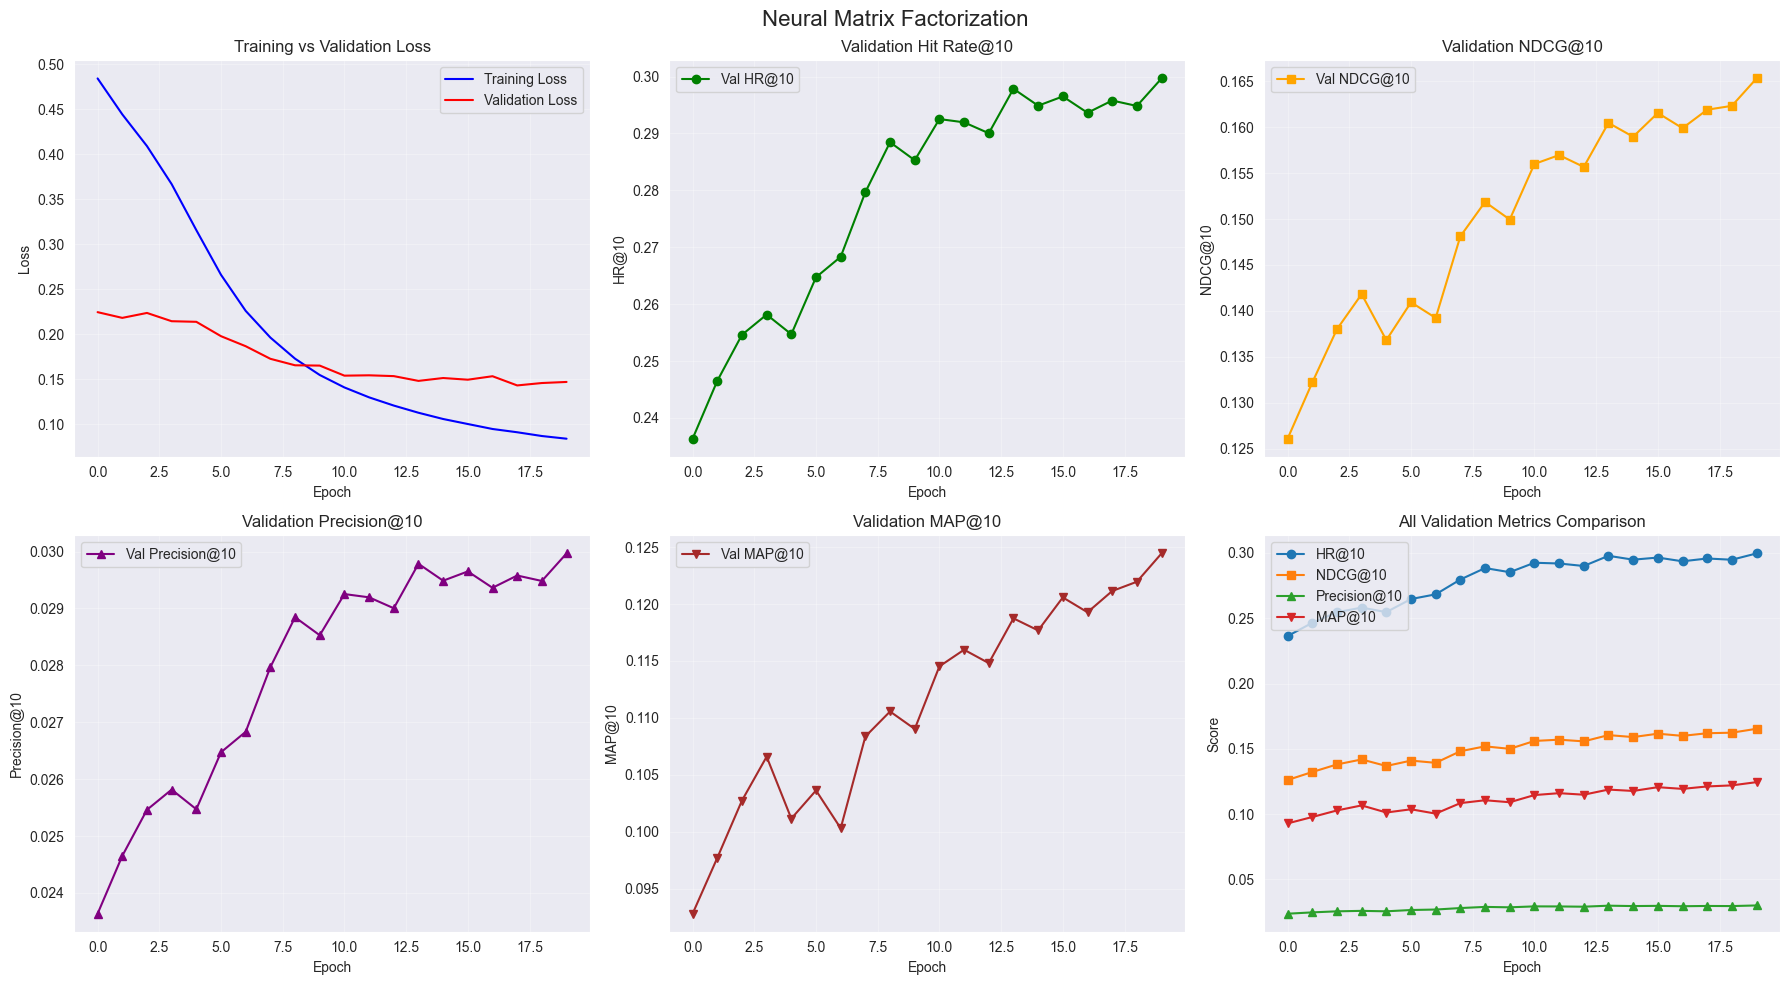

In [29]:
plot_training_history(
    train_losses_neumf,
    val_losses_neumf,
    val_metrics_neumf,
    k=10,
    model_name="Neural Matrix Factorization",
    save_path="training_history_neumf.png"
)

## Model 2: SASRec model
Transformer-based model for sequential recommendation from the paper [Self-Attentive Sequential Recommendation (2018)](https://arxiv.org/abs/1808.09781).

* **Data:** build per-user, time-sorted history sequences (left-padded to max length in batch). For training, use history -> next item triples + one negative per triples.
* **Model:** Item embeddings + positional embeddings -> Transformer encoder with causal mask. Take final position representation as the user's state and score candidate items by dot-product.

In [30]:
# Shift item ID by 1 to reserve 0 for padding
df_encoded_sasrec = df_encoded.copy()
df_encoded_sasrec["item_id"] += 1

SASREC_NUM_USERS = int(df_encoded_sasrec["user_id"].max()) + 1
SASREC_NUM_ITEMS = int(df_encoded_sasrec["item_id"].max()) + 1

In [31]:
def create_user_sequences(df):
    df_sorted = df.sort_values(["user_id", "timestamp"])
    user_sequences = {}
    for uid, group in df_sorted.groupby("user_id"):
        items = group["item_id"].tolist()
        user_sequences[uid] = items

    print(f"Number of users: {len(user_sequences)}")
    print(f"Max sequence length: {max(len(seq) for seq in user_sequences.values())}")
    print(f"Min sequence length: {min(len(seq) for seq in user_sequences.values())}")

    return user_sequences

# Create sequences
user_sequences = create_user_sequences(df_encoded_sasrec)
pos_items_by_user_sasrec = {u: set(seq) for u, seq in user_sequences.items()}

Number of users: 26817
Max sequence length: 219
Min sequence length: 1


In [32]:
def sequences_loo_split(user_sequences):
    train_seqs = {}
    val_data = {}
    test_data = {}

    for user, seq in user_sequences.items():
        if len(seq) < 3:  # Need at least 3 items for train/val/test
            continue

        train_seqs[user] = seq[:-2]  # All but last two
        val_data[user] = (seq[:-2], seq[-2])  # Train on all but last 2, predict second-to-last
        test_data[user] = (seq[:-1], seq[-1])  # Train on all but last, predict last

    print(f"Training sequences: {len(train_seqs)}")
    print(f"Validation users: {len(val_data)}")
    print(f"Test users: {len(test_data)}")

    return train_seqs, val_data, test_data

train_sequences, val_sequences, test_sequences = sequences_loo_split(user_sequences)
print(f"Sequences - Train: {len(train_sequences)}, Val: {len(val_sequences)}, Test: {len(test_sequences)}")

Training sequences: 20863
Validation users: 20863
Test users: 20863
Sequences - Train: 20863, Val: 20863, Test: 20863


### Dataset and DataLoader
SASRec uses sequences of user interactions to predict the next item. So for sequence `[i1, i2, i3, i4]`, the training samples are:
- Input: `[i1]` -> Target: `i2`
- Input: `[i1, i2]` -> Target: `i3`
- Input: `[i1, i2, i3]` -> Target: `i4`

In [33]:
class SASRecDataset(Dataset):
    def __init__(self, data, num_items, max_seq_len=50, pos_items_by_user=None, mode="train", neg_samples=1):
        self.num_items = num_items
        self.max_seq_len = max_seq_len
        self.mode = mode
        self.neg_samples = neg_samples
        self.all_pos = pos_items_by_user

        self.samples = []
        if mode == "train":
            for user, seq in data.items():
                for i in range(1, len(seq)):
                    self.samples.append({
                        "user": user,
                        "input_seq": seq[:i],
                        "target": seq[i],
                        "full_seq": seq # For negative sampling
                    })
        else:
            for user, (seq, target) in data.items():
                self.samples.append({
                    "user": user,
                    "input_seq": seq,
                    "target": target,
                    "full_seq": seq + [target]
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        user = sample["user"]
        seq = sample["input_seq"]
        target = sample["target"]

        # Truncate sequence if > max length
        if len(seq) > self.max_seq_len:
            seq = seq[-self.max_seq_len:]

        # Left-pad sequence with zeros
        pad_len = self.max_seq_len - len(seq)
        padded_seq = [0] * pad_len + seq

        # Negative sampling
        forbid = self.all_pos[user] if self.all_pos is not None else set(sample["full_seq"])
        neg_items = set()

        while len(neg_items) < self.neg_samples:
            neg = random.randint(1, self.num_items - 1)
            if neg not in forbid:
                neg_items.add(neg)

        return {
            "user": sample["user"],
            "input_seq": torch.tensor(padded_seq, dtype=torch.long),
            "target": torch.tensor(target, dtype=torch.long),
            "neg_items": torch.tensor(list(neg_items), dtype=torch.long)
        }

# Create datasets
train_ds_sasrec = SASRecDataset(train_sequences, SASREC_NUM_ITEMS, pos_items_by_user=pos_items_by_user_sasrec, max_seq_len=50, mode="train", neg_samples=4)
val_ds_sasrec = SASRecDataset(val_sequences, SASREC_NUM_ITEMS, pos_items_by_user=pos_items_by_user_sasrec, max_seq_len=50, mode="val", neg_samples=99)
test_ds_sasrec = SASRecDataset(test_sequences, SASREC_NUM_ITEMS, pos_items_by_user=pos_items_by_user_sasrec, max_seq_len=50, mode="test", neg_samples=99)

print(f"Training samples: {len(train_ds_sasrec)}")
print(f"Validation samples: {len(val_ds_sasrec)}")
print(f"Test samples: {len(test_ds_sasrec)}")

Training samples: 112131
Validation samples: 20863
Test samples: 20863


In [34]:
# Create data loaders
BATCH_SIZE = 512
train_loader_sasrec = DataLoader(train_ds_sasrec, batch_size=BATCH_SIZE, shuffle=True)
val_loader_sasrec = DataLoader(val_ds_sasrec, batch_size=BATCH_SIZE, shuffle=False)
test_loader_sasrec = DataLoader(test_ds_sasrec, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
# Sanity check
first = next(iter(train_loader_sasrec))
print("Sample batch from loader:")
print("Input sequence shape:", first["input_seq"].shape)
print("Target shape:", first["target"].shape)
print("Negative items shape:", first["neg_items"].shape)

print("\nSample input sequence:")
random_index = []
for _ in range(5):
    random_index.append(random.randint(0, len(train_loader_sasrec) - 1))

for i in random_index:
    print(first["input_seq"][i])

Sample batch from loader:
Input sequence shape: torch.Size([512, 50])
Target shape: torch.Size([512])
Negative items shape: torch.Size([512, 4])

Sample input sequence:
tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 44205, 45970, 46086, 46060, 44692, 46496, 42666])
tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0, 35526, 29257, 26373, 23727, 23550,  1584,   697, 30968])
tensor([    0,     0,     0,     0,     0,     0,

### Building the model

In [36]:
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_dim, dropout=0.2):
        super().__init__()
        self.w1 = nn.Linear(hidden_dim, hidden_dim)
        self.w2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(self.relu(self.w1(x))))

class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout=0.2):
        super().__init__()

        # Multi-head attention
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)

        # Layer norms
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

        # Feed-forward network
        self.ffn = PointWiseFeedForward(hidden_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None, key_padding_mask=None):
        # Self-attention with residual connection
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
        x = self.ln1(x + self.dropout(attn_out))

        # Feed-forward network with residual connection
        ffn_out = self.ffn(x)
        x = self.ln2(x + self.dropout(ffn_out))

        return x

class SASRec(nn.Module):
    def __init__(self,
                 num_items,
                 hidden_dim=64,
                 max_seq_len=50,
                 num_blocks=2,
                 num_heads=2,
                 dropout=0.2):
        super().__init__()

        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.max_seq_len = max_seq_len

        # Embedding layers
        self.item_embed = nn.Embedding(num_items, hidden_dim, padding_idx=0)
        self.positional_embed = nn.Embedding(max_seq_len, hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Stack of SASRec blocks
        self.blocks = nn.ModuleList([
            AttentionBlock(hidden_dim, num_heads, dropout) for _ in range(num_blocks)
        ])

        # Final layer norm
        self.ln = nn.LayerNorm(hidden_dim)

        # Initialize weights
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_normal_(self.item_embed.weight[1:])  # Skip padding idx
        nn.init.xavier_normal_(self.positional_embed.weight)

    def forward(self, input_seq, candidate_items=None):
        batch_size, seq_len = input_seq.shape

        # Get item embeddings
        item_embeds = self.item_embed(input_seq)  # [B, L, D]

        # Add positional embeddings
        positions = torch.arange(seq_len, device=input_seq.device).unsqueeze(0).expand(batch_size, seq_len)  # [B, L]
        pos_embeds = self.positional_embed(positions)  # [1, L, D]
        x = self.dropout(item_embeds + pos_embeds)

        # Create causal attention mask
        attn_mask = self._create_causal_mask(seq_len, input_seq.device)
        pad_mask = input_seq.eq(0)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x, attn_mask=attn_mask)

        # Final layer norm
        x = self.ln(x)  # [B, L, D]
        x = x.masked_fill(pad_mask.unsqueeze(-1), 0.0)

        # If candidate_items provided, score them
        if candidate_items is not None:
            # Get embeddings for candidate items
            cand_emb = self.item_embed(candidate_items) # [B, N, D]

            # Use last position's representation for scoring
            last_hidden = x[:, -1, :].unsqueeze(1)  # [B, 1, D]

            # Compute scores via dot product
            scores = torch.matmul(last_hidden, cand_emb.transpose(1, 2)).squeeze(1) # [B, N]
            return scores

        return x

    def _create_causal_mask(self, seq_len, device):
        # mask = torch.triu(torch.ones(seq_len, seq_len, device=device, dtype=torch.bool), diagonal=1)
        # mask = mask.masked_fill(mask == 1, float("-inf"))
        mask = torch.full((seq_len, seq_len), 0.0, device=device)
        mask = mask.masked_fill(torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool(), float('-inf'))
        return mask

    def predict_next(self, input_seq):
        # Get sequence representations
        seq_repr = self.forward(input_seq)  # [B, L, D]

        # Use last position for prediction
        last_hidden = seq_repr[:, -1, :]  # [B, D]

        # Score against all item embeddings
        all_item_embeds = self.item_embed.weight  # [num_items, D]
        scores = torch.matmul(last_hidden, all_item_embeds.T)  # [B, num_items]
        return scores

### Training and evaluation functions

In [37]:
def train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_seq = batch["input_seq"].to(device)
        pos_items = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        # Get predictions for last position
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]

        # Get embeddings for positive and negative items
        pos_embeds = model.item_embed(pos_items)
        neg_embeds = model.item_embed(neg_items)

        # Compute logits
        pos_logits = (last_hidden * pos_embeds).sum(dim=1)
        neg_logits = torch.bmm(neg_embeds, last_hidden.unsqueeze(-1)).squeeze(-1)

        # Binary cross-entropy loss with logits
        pos_labels = torch.ones_like(pos_logits)
        neg_labels = torch.zeros_like(neg_logits)

        # Concatenate logits and labels
        all_logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)

        loss = loss_fn(all_logits, all_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_batches += 1

    return total_loss / n_batches

In [38]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate_sasrec(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_mrr = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for batch in tqdm(eval_loader, desc="Evaluating"):
        input_seq = batch["input_seq"].to(device)
        target = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        batch_size = input_seq.size(0)

        # Create candidate set: 1 positive + negatives
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]
        candidates = torch.cat([
            target.unsqueeze(1),  # [B, 1]
            neg_items  # [B, neg_samples]
        ], dim=1)  # [B, 1 + neg_samples]

        # Get embeddings for all candidates
        cand_emb = model.item_embed(candidates)  # [B, 1+neg_samples, D]
        scores = torch.bmm(cand_emb, last_hidden.unsqueeze(-1)).squeeze(-1)  # [B, 1+neg_samples]

        # sanity: positive not in negatives
        if torch.any((candidates[:, 1:] == target.unsqueeze(1)).any(dim=1)):
            raise RuntimeError("Positive item appeared in negatives for some samples.")

        # Loss calculation
        pos_scores = scores[:, 0]
        neg_scores = scores[:, 1:]
        pos_labels = torch.ones_like(scores[:, 0])
        neg_labels = torch.zeros_like(scores[:, 1:])
        all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)
        batch_loss = loss_fn(all_scores.reshape(-1), all_labels.reshape(-1))
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

        # Calculate metrics
        _, full_idx = torch.sort(scores, dim=1, descending=True)
        rank  = (full_idx == 0).nonzero(as_tuple=True)[1] + 1  # Rank of the positive item (1-based)

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        mrr = torch.where(rank <= k, 1.0 / rank.float(), torch.zeros_like(hit))

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_mrr += mrr.sum().item()
        total += batch_size

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MRR@K": sum_mrr / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }

    return metrics

In [39]:
def sasrec_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        t0 = time.time()

        # Train (batched)
        train_loss = train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device=device)
        train_losses.append(train_loss)

        # Eval (batched)
        m = evaluate_sasrec(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MRR@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
        writer.add_scalar(f"Metrics/Val_MRR@{k}", m["MRR@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MRR@{k} {m['MRR@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    print("\nTraining Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

### Training the SASRec model

In [41]:
# Hyperparameters from the original paper, except higher hidden_dim
sasrec = SASRec(
    num_items=SASREC_NUM_ITEMS,
    hidden_dim=64,
    max_seq_len=50,
    num_blocks=2,
    num_heads=2,
    dropout=0.4
)

loss_fn_sasrec = nn.BCEWithLogitsLoss()
optimizer_sasrec = torch.optim.Adam(sasrec.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses_sasrec, val_losses_sasrec, val_metrics_sasrec, best_ndcg_sasrec = sasrec_trainer(
    model=sasrec,
    train_loader=train_loader_sasrec,
    eval_loader=val_loader_sasrec,
    loss_fn=loss_fn_sasrec,
    optimizer=optimizer_sasrec,
    epochs=20,
    k=10,
    device=DEVICE,
    save_dir="model_sasrec"
)

Evaluating: 100%|██████████| 41/41 [00:02<00:00, 14.08it/s]


Epoch 1/20  Train loss 0.5532  Val loss 0.2760  HR@10 0.2263  NDCG@10 0.1187  Precision@10 0.0226  MRR@10 0.0864  (new best)  Time 19.33s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 13.90it/s]


Epoch 2/20  Train loss 0.4516  Val loss 0.2513  HR@10 0.2293  NDCG@10 0.1229  Precision@10 0.0229  MRR@10 0.0909  (new best)  Time 18.86s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 14.90it/s]


Epoch 3/20  Train loss 0.4372  Val loss 0.2500  HR@10 0.2373  NDCG@10 0.1255  Precision@10 0.0237  MRR@10 0.0917  (new best)  Time 18.24s


Evaluating: 100%|██████████| 41/41 [00:03<00:00, 13.43it/s]


Epoch 4/20  Train loss 0.4292  Val loss 0.2449  HR@10 0.2424  NDCG@10 0.1301  Precision@10 0.0242  MRR@10 0.0963  (new best)  Time 18.95s


Evaluating: 100%|██████████| 41/41 [00:03<00:00, 12.23it/s]


Epoch 5/20  Train loss 0.4187  Val loss 0.2648  HR@10 0.2452  NDCG@10 0.1321  Precision@10 0.0245  MRR@10 0.0979  (new best)  Time 20.09s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 14.75it/s]


Epoch 6/20  Train loss 0.4039  Val loss 0.2491  HR@10 0.2592  NDCG@10 0.1404  Precision@10 0.0259  MRR@10 0.1045  (new best)  Time 17.11s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 16.87it/s]


Epoch 7/20  Train loss 0.3863  Val loss 0.2548  HR@10 0.2724  NDCG@10 0.1471  Precision@10 0.0272  MRR@10 0.1091  (new best)  Time 14.03s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 17.60it/s]


Epoch 8/20  Train loss 0.3663  Val loss 0.2380  HR@10 0.2925  NDCG@10 0.1586  Precision@10 0.0293  MRR@10 0.1180  (new best)  Time 12.89s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 14.64it/s]


Epoch 9/20  Train loss 0.3383  Val loss 0.2253  HR@10 0.3069  NDCG@10 0.1678  Precision@10 0.0307  MRR@10 0.1257  (new best)  Time 13.16s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 17.01it/s]


Epoch 10/20  Train loss 0.3053  Val loss 0.2212  HR@10 0.3152  NDCG@10 0.1737  Precision@10 0.0315  MRR@10 0.1308  (new best)  Time 12.95s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 17.15it/s]


Epoch 11/20  Train loss 0.2697  Val loss 0.2045  HR@10 0.3226  NDCG@10 0.1779  Precision@10 0.0323  MRR@10 0.1340  (new best)  Time 13.32s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 15.80it/s]


Epoch 12/20  Train loss 0.2338  Val loss 0.1870  HR@10 0.3289  NDCG@10 0.1831  Precision@10 0.0329  MRR@10 0.1388  (new best)  Time 13.16s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 14.28it/s]


Epoch 13/20  Train loss 0.2010  Val loss 0.1688  HR@10 0.3300  NDCG@10 0.1859  Precision@10 0.0330  MRR@10 0.1419  (new best)  Time 13.95s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 16.18it/s]


Epoch 14/20  Train loss 0.1754  Val loss 0.1587  HR@10 0.3339  NDCG@10 0.1895  Precision@10 0.0334  MRR@10 0.1455  (new best)  Time 13.33s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 16.39it/s]


Epoch 15/20  Train loss 0.1535  Val loss 0.1444  HR@10 0.3355  NDCG@10 0.1935  Precision@10 0.0336  MRR@10 0.1503  (new best)  Time 13.60s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 16.51it/s]


Epoch 16/20  Train loss 0.1363  Val loss 0.1372  HR@10 0.3361  NDCG@10 0.1948  Precision@10 0.0336  MRR@10 0.1517  (new best)  Time 13.33s


Evaluating: 100%|██████████| 41/41 [00:03<00:00, 12.28it/s]


Epoch 17/20  Train loss 0.1215  Val loss 0.1243  HR@10 0.3426  NDCG@10 0.2002  Precision@10 0.0343  MRR@10 0.1568  (new best)  Time 14.22s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 16.49it/s]


Epoch 18/20  Train loss 0.1091  Val loss 0.1167  HR@10 0.3421  NDCG@10 0.1996  Precision@10 0.0342  MRR@10 0.1562    Time 13.45s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 15.87it/s]


Epoch 19/20  Train loss 0.1011  Val loss 0.1135  HR@10 0.3432  NDCG@10 0.2026  Precision@10 0.0343  MRR@10 0.1597  (new best)  Time 13.89s


Evaluating: 100%|██████████| 41/41 [00:02<00:00, 16.32it/s]


Epoch 20/20  Train loss 0.0936  Val loss 0.1098  HR@10 0.3416  NDCG@10 0.2023  Precision@10 0.0342  MRR@10 0.1598    Time 13.64s

Training Complete.
Best epoch: 19 with NDCG@10: 0.2026



### Final evaluation on test set

In [42]:
best_sasrec = load_best_weights(sasrec, ckpt_path="model_sasrec/best_model.pth", device=DEVICE)

In [43]:
# Final evaluation on test set
@torch.no_grad()
def final_evaluation_sasrec(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate_sasrec(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

results_df_sasrec = final_evaluation_sasrec(best_sasrec, test_loader_sasrec, loss_fn_sasrec, device=DEVICE)

Evaluating: 100%|██████████| 41/41 [00:02<00:00, 14.90it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.2034  0.1410       0.0407
10 0.2909  0.1680       0.0291
20 0.4129  0.1987       0.0206
50 0.6320  0.2426       0.0126


In [44]:
@torch.no_grad()
def get_recommendations_sasrec(
        model,
        user_id,
        input_seq,
        pos_items_by_user,
        item_encoder,
        top_k=10,
        exclude_interacted=True,
        device="cpu"):

    model.eval()

    if len(input_seq) > model.max_seq_len:
        processed_seq = input_seq[-model.max_seq_len:]
    elif len(input_seq) < model.max_seq_len:
        processed_seq = [0] * (model.max_seq_len - len(input_seq)) + input_seq
    else:
        processed_seq = input_seq

    input_tensor = torch.tensor([processed_seq], dtype=torch.long, device=device)
    scores = model.predict_next(input_tensor).squeeze(0)

    # Exclude items the user has already interacted with
    if exclude_interacted and user_id in pos_items_by_user:
        interacted_indices = torch.as_tensor(
            list(pos_items_by_user[user_id]),
            dtype=torch.long,
            device=device
        )
        if interacted_indices.numel() > 0:
            scores.index_fill_(0, interacted_indices, float("-inf"))

    top_scores, top_indices = torch.topk(scores, top_k)
    item_ids_np = top_indices.detach().cpu().numpy()
    items_np = item_encoder.inverse_transform(item_ids_np)

    return [
        {"item_id": int(i), "item": it, "score": float(s)}
        for i, it, s in zip(item_ids_np, items_np, top_scores.detach().cpu().numpy())
    ]

In [45]:
def show_sample_recommendations_sasrec(
    model,
    df,
    user_encoder,
    item_encoder,
    pos_items_by_user,    # Used for filtering recommendations
    history_by_user,      # Used to get the input sequence for the model
    device,
    num_users=5,
    top_k=10):

    print("\n" + "="*50)
    print("SASRec - User Sample Recommendations")
    print("="*50)

    user_candidates = df["user_id"].unique().tolist()
    num_to_sample = min(num_users, len(user_candidates))

    for user_id in random.sample(user_candidates, k=num_to_sample):
        original_user = user_encoder.inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        # Get the user's interaction history to show and to use as model input
        user_history_seq = history_by_user.get(user_id, [])

        # Display the 5 most recent interactions
        recent_interactions = user_history_seq[-5:]
        print("Recent interactions (most recent first):")
        for item_id in reversed(recent_interactions):
            item_name = item_encoder.inverse_transform([item_id])[0]
            print(f"  - {item_name} (ID: {item_id})")

        # Get recommendations using the adapted function
        recs = get_recommendations_sasrec(
            model=model,
            user_id=user_id,
            input_seq=user_history_seq, # Pass the full history as input
            pos_items_by_user=pos_items_by_user,
            item_encoder=item_encoder,
            device=device,
            top_k=top_k,
            exclude_interacted=True
        )

        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec['item']} (ID: {rec['item_id']}, Score: {rec['score']:.4f})")

In [46]:
show_sample_recommendations_sasrec(
    model=best_sasrec,
    df=df_encoded,
    user_encoder=user_enc,
    item_encoder=item_enc,
    pos_items_by_user=pos_items_by_user,
    history_by_user=history_by_user_train,
    device=DEVICE,
    num_users=5,
    top_k=10
)


SASRec - User Sample Recommendations

User: AFBVYTZOW7ZVXAJPVMCIMUORNV5Q (ID: 8446)
----------------------------------------
Recent interactions (most recent first):
  - 0399168796 (ID: 10179)
  - 0399159304 (ID: 10066)

Top 10 Recommendations:
  1. 1338102494 (ID: 24623, Score: 8.8885)
  2. 0062407201 (ID: 2086, Score: 5.7581)
  3. 1476746826 (ID: 28901, Score: 5.5084)
  4. 0061953385 (ID: 1140, Score: 4.7373)
  5. 0553573527 (ID: 15050, Score: 4.5809)
  6. 1409103803 (ID: 25669, Score: 4.4557)
  7. 0062060589 (ID: 1356, Score: 4.2942)
  8. 0451458508 (ID: 12440, Score: 3.8719)
  9. 0439023521 (ID: 11082, Score: 3.8527)
  10. 0375842381 (ID: 8396, Score: 3.7545)

User: AE6MYCSTIPESAYDSYKCR7Z62NORA (ID: 962)
----------------------------------------
Recent interactions (most recent first):
  - B00SLWQGUM (ID: 43411)
  - B0043VDX1A (ID: 39147)
  - B00N5W2E4U (ID: 42987)
  - B00M0CL4P6 (ID: 42879)
  - B00676171W (ID: 40071)

Top 10 Recommendations:
  1. B00ASCMDFK (ID: 41221, Score: 7.11

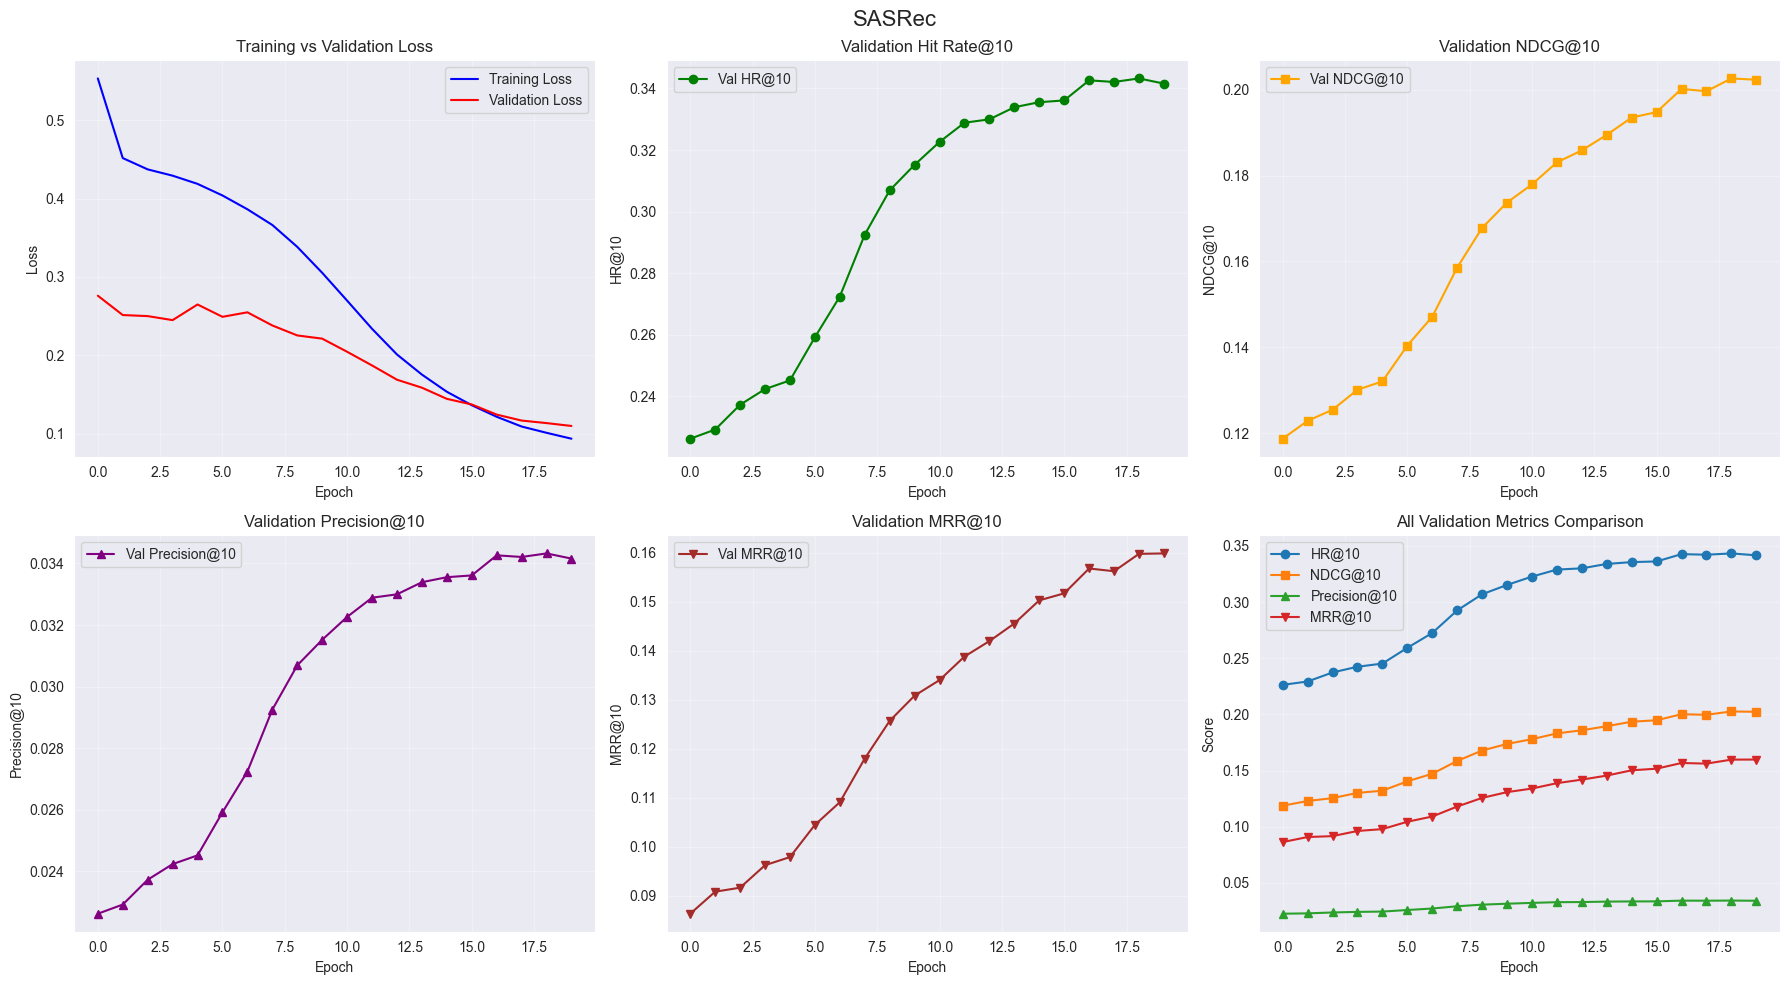

In [47]:
plot_training_history(
    train_losses_sasrec,
    val_losses_sasrec,
    val_metrics_sasrec,
    k=10,
    model_name="SASRec",
    save_path="training_history_sasrec.png"
)

## Comparison of all three models

In [48]:
# Plot metrics comparison at different K values
def plot_comparison(results_list, model_names, metric="NDCG@K", save_path="model_comparison.png"):
    plt.figure(figsize=(8, 6))
    for results, name in zip(results_list, model_names):
        plt.plot(results.index, results[metric], marker='o', label=name)
    plt.title(f"Comparison of {metric} Across Models in a Single Domain (Amazon Books)")
    plt.xlabel("K")
    plt.ylabel(metric)
    plt.xticks(results_list[0].index)
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

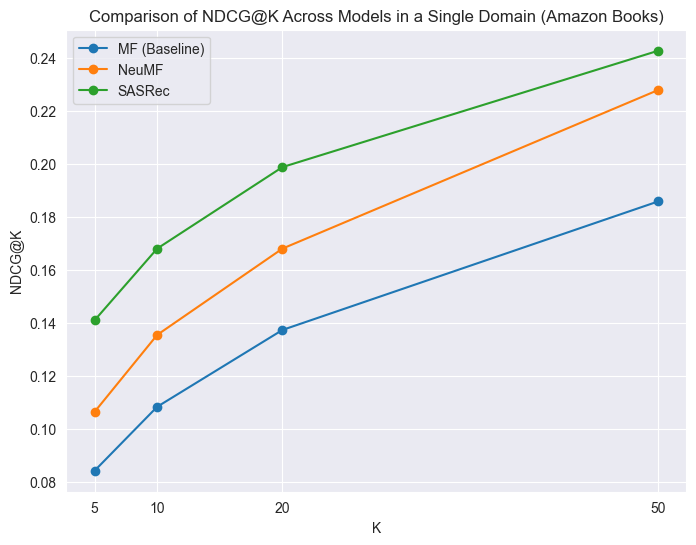

In [49]:
results_list = [results_df_mf, results_df_neumf, results_df_sasrec]
model_names = ["MF (Baseline)", "NeuMF", "SASRec"]
plot_comparison(results_list, model_names, metric="NDCG@K", save_path="ndcg_comparison.png")

In [50]:
# Metrics table comparison
@torch.no_grad()
def final_evaluation_sasrec(model, test_loader, loss_fn, k_values=(5, 10, 20, 50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate_sasrec(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics.get("HR@K", float("nan")),
            "NDCG@K": metrics.get("NDCG@K", float("nan")),
            "Precision@K": metrics.get("Precision@K", float("nan")),
            "MRR@K": metrics.get("MRR@K", float("nan")),
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

# Recompute SASRec results (now with MRR@K)
results_df_sasrec = final_evaluation_sasrec(best_sasrec, test_loader_sasrec, loss_fn_sasrec, device=DEVICE)

# --- Build model comparison table at a chosen K ---
def pick_ranking_key(cols):
    return "MAP@K" if "MAP@K" in cols else ("MRR@K" if "MRR@K" in cols else None)

def build_row(name, df, k):
    row = {
        "Model": name,
        f"HR@{k}": float(df.loc[k, "HR@K"]),
        f"NDCG@{k}": float(df.loc[k, "NDCG@K"]),
        f"Precision@{k}": float(df.loc[k, "Precision@K"]),
    }
    r_key = pick_ranking_key(df.columns)
    row[f"Ranking@{k}"] = float(df.loc[k, r_key]) if r_key is not None else float("nan")
    row["RankingMetric"] = (r_key or "N/A").replace("@K", f"@{k}") if r_key else "N/A"
    return row

K_COMPARE = 10
comparison_rows = [
    build_row("MF", results_df_mf, K_COMPARE),
    build_row("NeuMF", results_df_neumf, K_COMPARE),
    build_row("SASRec", results_df_sasrec, K_COMPARE),
]
comparison_df = pd.DataFrame(comparison_rows).set_index("Model")

print("\nModel comparison at K =", K_COMPARE)
print(comparison_df.to_string(float_format=lambda x: f"{x:.4f}"))

Evaluating: 100%|██████████| 41/41 [00:02<00:00, 14.81it/s]

     HR@K  NDCG@K  Precision@K  MRR@K
K                                    
5  0.2030  0.1409       0.0406 0.1205
10 0.2932  0.1686       0.0293 0.1308
20 0.4137  0.1990       0.0207 0.1391
50 0.6292  0.2425       0.0126 0.1471

Model comparison at K = 10
        HR@10  NDCG@10  Precision@10  Ranking@10 RankingMetric
Model                                                         
MF     0.2046   0.1084        0.0205      0.0793        MAP@10
NeuMF  0.2535   0.1355        0.0253      0.0997        MAP@10
SASRec 0.2932   0.1686        0.0293      0.1308        MRR@10
